# COMPAS FTU Model Bias Analysis
mk4

### 1) Dependencies
### 2) Custom Functions
### 3) Import Data
### 4) Bias Analysis

## Import Dependencies

In [1]:
# !pip install researchpy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
import math
import os

In [4]:
from dataclasses import dataclass
from sklearn.metrics import confusion_matrix

In [5]:
warnings.filterwarnings('ignore')

%matplotlib inline

In [6]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

# Custom functions

#### Custom Save

In [7]:
def custom_save(name, data, kind=1):
    '''
    name : string
        designated filename
    data : data or pytorch model
        the data to save
    kind : int
        sentinel value - 1 if pytorch model, 0 otherwise
    
    custom_save stores the data passed into the function into a file with the provided name
    '''
    
    if kind == 1:
        ex = ".pth"
    else:
        ex = ".parquet"
    
    sentinel = True
    i = 1

    while sentinel:
        dirlist = os.listdir()

        if name not in dirlist:
            if kind == 1:
                torch.save(data, name)
            else:
                data.to_parquet(name)
            print(f"{name} has been saved.")                
            sentinel = False
        if name in dirlist:
            print(f"{name} already exists.", end=" ")
            temp, ext = name.split(ex)
            if "_v" in temp:
                temp, _ = temp.split("_v")
            name = f"{temp}_v{i}{ex}"
            i = i + 1
            print(f"Changing file name to: {name}")

#### Dataclass for confusion matrix results

In [8]:
@dataclass
class cmatrix:
    name: str
    TP: int
    FP: int
    TN: int
    FN: int    
    PPV: float
    TPR: float
    FDR: float
    FPR: float
    FOR: float
    FNR: float
    NPV: float
    TNR: float

#### Helper function to generate dataclass _cmatrix_

In [9]:
def gen_dataclass(actual, pred, name):
    [TN, FP, FN, TP] = confusion_matrix(actual, pred).ravel()
    

    PPV = TP / (TP + FP)  # positive predictive value
    FDR = FP / (TP + FP)  # false discovery rate
    
    TPR = TP / (TP + FN)  # true positive rate
    FNR = FN / (TP + FN)  # false negative rate
    
    TNR = TN / (TN + FP)  # true negative rate
    FPR = FP / (TN + FP)  # false positive rate

    FOR = FN / (TN + FN)  # false omission rate
    NPV = TN / (TN + FN)  # negative predictive value

    
    return cmatrix(name, TP, FP, TN, FN, PPV, TPR, FDR, FPR, FOR, FNR, NPV, TNR)

#### Extract bias metrics

In [10]:
def bias_metrics(df):
    '''
    - takes dataframe as input
    - returns dataclass whose components are statistical measures from a confusion matrix
    particular to relu, tanh, elu, and leaky relu dataframe series
    '''
    actual = df.target.values
    relu = df.pred_relu.values
    tanh = df.pred_tanh.values
    elu = df.pred_elu.values
    leaky = df.pred_leaky.values
    
    relu = gen_dataclass(actual, relu, "relu")
    tanh = gen_dataclass(actual, tanh, "tanh")
    elu = gen_dataclass(actual, elu, "elu")
    leaky = gen_dataclass(actual, leaky, "leaky")
    
    return relu, tanh, elu, leaky

# Import Data

In [11]:
data = pd.read_parquet("compas_results_mk2_FTU.parquet")

source = "COMPAS_FTU"
suffix = "mk4"
name = f"{source}_stats_{suffix}.parquet"
tag = ["Ground", "Group A", "Group B"]

In [12]:
data.head()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,sex,age_cat_25to45,age_cat_over45,age_cat_under25,race_asian,c_charge_degree,score_text_High,score_text_Low,score_text_Medium,v_score_text_High,v_score_text_Low,v_score_text_Medium,event,black,white,hispanic,native,other,target,pred_relu,pred_tanh,pred_elu,pred_leaky
0,25,0,5,0,1,4,-1,1,1,0,5,4,4,32,304,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1,1,1,1
1,35,0,4,0,0,3,-1,0,1,0,4,4,3,9,462,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,1,1,1
2,32,0,4,0,0,1,0,0,0,0,4,3,1,0,1171,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,20,0,10,0,0,0,-1,1,1,1,10,10,0,3,20,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,1,1,1,1
4,50,0,8,0,2,24,0,1,1,1,8,8,24,32,87,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1


In [13]:
features = list(data.columns[-5:])
features

['target', 'pred_relu', 'pred_tanh', 'pred_elu', 'pred_leaky']

#### Inspect Data

**Note:** The following confusion matrix should return a list of four (4) numbers, with zero (0) false negatives and false positives. Example: array([100, 0, 0, 10])

In [14]:
confusion_matrix(data.target, data.target).ravel()

array([1114,    0,    0,  959])

In [99]:
l = 43
title = f" * {source} Confusion Matrix, Tabular *"
t = len(title)
offset = l//2 - t//2

print(" "*offset + title)
print("-"*l)
print("Name\t    Total   TP     FP    TN     FN")
for f in features:
    total = data[f].shape[0]
    try:
        [tn, fp, fn, tp] = confusion_matrix(data.target, data[f]).ravel()
    except Exception:
        pass
    print(f"{f:10s}: {total:5.0f}  {tp:5.0f} {fp:5.0f} {tn:6.0f} {fn:5.0f}")

  * COMPAS_FTU Confusion Matrix, Tabular *
-------------------------------------------
Name	    Total   TP     FP    TN     FN
target    :  2073    959     0   1114     0
pred_relu :  2073    910   116    998    49
pred_tanh :  2073    909    72   1042    50
pred_elu  :  2073    847    89   1025   112
pred_leaky:  2073    917   111   1003    42


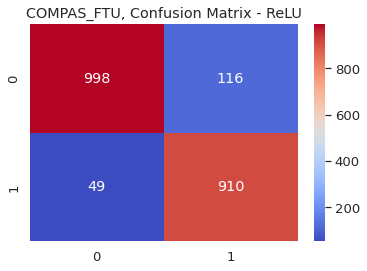

In [95]:
cm_relu = confusion_matrix(data.target, data.pred_relu)
sns.set(font_scale=1.2)
sns.heatmap(cm_relu, annot=True, cmap="coolwarm", robust=True, fmt='g')
plt.title(f"{source}, Confusion Matrix - ReLU")
plt.savefig("compas - FTU cm relu.png")
plt.show()

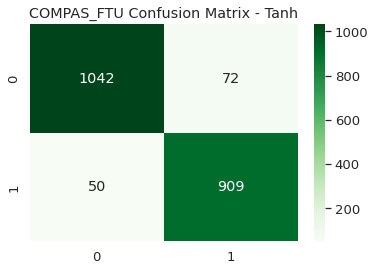

In [96]:
cm_tanh = confusion_matrix(data.target, data.pred_tanh)
sns.set(font_scale=1.2)
sns.heatmap(cm_tanh, annot=True, cmap="Greens", robust=True, fmt='g')
plt.title(f"{source} Confusion Matrix - Tanh")
plt.savefig("compas - FTU cm tanh.png")
plt.show()

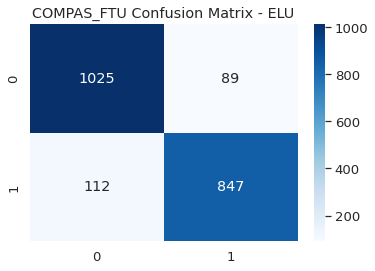

In [97]:
cm_elu = confusion_matrix(data.target, data.pred_elu)
sns.set(font_scale=1.2)
sns.heatmap(cm_elu, annot=True, cmap="Blues", robust=True, fmt='g')
plt.title(f"{source} Confusion Matrix - ELU")
plt.savefig("compas - FTU cm elu.png")
plt.show()

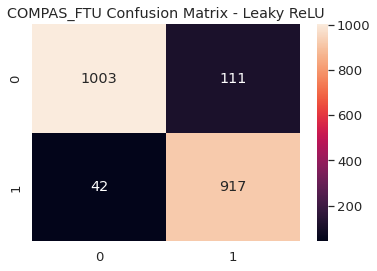

In [98]:
cm_leaky = confusion_matrix(data.target, data.pred_leaky)
sns.set(font_scale=1.2)
sns.heatmap(cm_leaky, annot=True, fmt='g')
plt.title(f"{source} Confusion Matrix - Leaky ReLU")
plt.savefig("compas - FTU cm leaky.png")
plt.show()

## Separate by protected feature

In [20]:
list(data.columns)

['age',
 'juv_fel_count',
 'decile_score',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'days_b_screening_arrest',
 'c_days_from_compas',
 'is_recid',
 'is_violent_recid',
 'decile_score.1',
 'v_decile_score',
 'priors_count.1',
 'start',
 'end',
 'sex',
 'age_cat_25to45',
 'age_cat_over45',
 'age_cat_under25',
 'race_asian',
 'c_charge_degree',
 'score_text_High',
 'score_text_Low',
 'score_text_Medium',
 'v_score_text_High',
 'v_score_text_Low',
 'v_score_text_Medium',
 'event',
 'black',
 'white',
 'hispanic',
 'native',
 'other',
 'target',
 'pred_relu',
 'pred_tanh',
 'pred_elu',
 'pred_leaky']

In [21]:
# group A : protected attribute
# group B : other
GroupA = data[data["black"] == 1]
GroupB = data[data["white"] == 1]
attribute = ["black", "white"]
protected_features = ["black", "white"]

In [22]:
Aset = GroupA.iloc[:,-5:]
Bset = GroupB.iloc[:,-5:]
base = data.iloc[:,-5:]

In [23]:
GroupA.shape

(1075, 38)

In [24]:
GroupB.shape

(697, 38)

In [25]:
data.shape

(2073, 38)

##### Control stats, baseline

In [26]:
Cr, Ct, Ce, Cl = bias_metrics(data)

In [27]:
Ct.TPR

0.9478623566214807

##### Stats for Group A and Group B dataframes

In [28]:
Ar, At, Ae, Al = bias_metrics(GroupA)
Br, Bt, Be, Bl = bias_metrics(GroupB)

In [29]:
At.TPR

0.9609236234458259

# Bias Testing

#### Set α (alpha)

In [30]:
α = 0.01

#### Predictive parity

Compares precision (or positive predictive value, PPV) between group with protected attribute and without protected attribute. In this instance female group with male group

In [31]:
ppCA = [
    math.isclose(Cr.PPV, Ar.PPV, rel_tol=α),
    math.isclose(Ct.PPV, At.PPV, rel_tol=α),
    math.isclose(Ce.PPV, Ae.PPV, rel_tol=α),
    math.isclose(Cl.PPV, Al.PPV, rel_tol=α)
]

In [32]:
ppCB = [
    math.isclose(Cr.PPV, Br.PPV, rel_tol=α),
    math.isclose(Ct.PPV, Bt.PPV, rel_tol=α),
    math.isclose(Ce.PPV, Be.PPV, rel_tol=α),
    math.isclose(Cl.PPV, Bl.PPV, rel_tol=α)
]

In [33]:
ppAB = [
    math.isclose(Br.PPV, Ar.PPV, rel_tol=α),
    math.isclose(Bt.PPV, At.PPV, rel_tol=α),
    math.isclose(Be.PPV, Ae.PPV, rel_tol=α),
    math.isclose(Bl.PPV, Al.PPV, rel_tol=α)  
]

In [34]:
title = f"* * * Predictive Parity, {source} * * *"
t = len(title)
l = 60
offset = l//2 - t//2
print(" "*offset + title)
one = "G & A"
two = "G & B"
three = "A & B"
print(f"Name\t{one}\t{two}\t{three}\t{tag[0]:10s} {tag[1]:10s}{tag[2]:11s}")
print("-"*l)
print(f"{Ar.name}\t{ppCA[0]}\t{ppCB[0]}\t{ppAB[0]}\t{Cr.PPV:<10.5f} {Ar.PPV:<10.5f}{Br.PPV:<10.5f}")
print(f"{At.name}\t{ppCA[1]}\t{ppCB[1]}\t{ppAB[1]}\t{Ct.PPV:<10.5f} {At.PPV:<10.5f}{Bt.PPV:<10.5f}")
print(f"{Ae.name}\t{ppCA[2]}\t{ppCB[2]}\t{ppAB[2]}\t{Ce.PPV:<10.5f} {Ae.PPV:<10.5f}{Be.PPV:<10.5f}")
print(f"{Al.name}\t{ppCA[3]}\t{ppCB[3]}\t{ppAB[3]}\t{Cl.PPV:<10.5f} {Al.PPV:<10.5f}{Bl.PPV:<10.5f}")

          * * * Predictive Parity, COMPAS_FTU * * *
Name	G & A	G & B	A & B	Ground     Group A   Group B    
------------------------------------------------------------
relu	True	False	False	0.88694    0.87825   0.90572   
tanh	True	False	False	0.92661    0.92479   0.94077   
elu	False	False	False	0.90491    0.89175   0.93385   
leaky	False	False	False	0.89202    0.88103   0.91216   


In [35]:
Cr

cmatrix(name='relu', TP=910, FP=116, TN=998, FN=49, PPV=0.8869395711500975, TPR=0.948905109489051, FDR=0.11306042884990253, FPR=0.10412926391382406, FOR=0.04680038204393505, FNR=0.051094890510948905, NPV=0.9531996179560649, TNR=0.895870736086176)

#### Predictive Equality

Also called the False Positive Error Balance, this metric considers compares the false positive rates (FPR) between groups.

In [36]:
peCA = [
    math.isclose(Cr.FPR, Ar.FPR, rel_tol=α),
    math.isclose(Ct.FPR, At.FPR, rel_tol=α),
    math.isclose(Ce.FPR, Ae.FPR, rel_tol=α),
    math.isclose(Cl.FPR, Al.FPR, rel_tol=α)
]

In [37]:
peCB = [
    math.isclose(Cr.FPR, Br.FPR, rel_tol=α),
    math.isclose(Ct.FPR, Bt.FPR, rel_tol=α),
    math.isclose(Ce.FPR, Be.FPR, rel_tol=α),
    math.isclose(Cl.FPR, Bl.FPR, rel_tol=α)
]

In [38]:
peAB = [
    math.isclose(Br.FPR, Ar.FPR, rel_tol=α),
    math.isclose(Bt.FPR, At.FPR, rel_tol=α),
    math.isclose(Be.FPR, Ae.FPR, rel_tol=α),
    math.isclose(Bl.FPR, Al.FPR, rel_tol=α)  
]

In [39]:
title = f"* * * Predictive Equality, {source} * * *"
t = len(title)
l = 60
offset = l//2 - t//2
print(" "*offset + title)
one = "G & A"
two = "G & B"
three = "A & B"
print(f"Name\t{one}\t{two}\t{three}\t{tag[0]:10s} {tag[1]:10s}{tag[2]:11s}")
print("-"*l)
print(f"{Ar.name}\t{peCA[0]}\t{peCB[0]}\t{peAB[0]}\t{Cr.FPR:<10.5f} {Ar.FPR:<10.5f}{Br.FPR:<10.5f}")
print(f"{At.name}\t{peCA[1]}\t{peCB[1]}\t{peAB[1]}\t{Ct.FPR:<10.5f} {At.FPR:<10.5f}{Bt.FPR:<10.5f}")
print(f"{Ae.name}\t{peCA[2]}\t{peCB[2]}\t{peAB[2]}\t{Ce.FPR:<10.5f} {Ae.FPR:<10.5f}{Be.FPR:<10.5f}")
print(f"{Al.name}\t{peCA[3]}\t{peCB[3]}\t{peAB[3]}\t{Cl.FPR:<10.5f} {Al.FPR:<10.5f}{Bl.FPR:<10.5f}")

         * * * Predictive Equality, COMPAS_FTU * * *
Name	G & A	G & B	A & B	Ground     Group A   Group B    
------------------------------------------------------------
relu	False	False	False	0.10413    0.14648   0.06897   
tanh	False	False	False	0.06463    0.08594   0.04187   
elu	False	False	False	0.07989    0.12305   0.04187   
leaky	False	False	False	0.09964    0.14453   0.06404   


#### Equal opportunity

Equal Opportunity entails equal false negative rates (FNR) between groups. Mathematically, true postive rates (TPR) should also be equal.

In [40]:
eoCA = [
    math.isclose(Cr.FNR, Ar.FNR, rel_tol=α),
    math.isclose(Ct.FNR, At.FNR, rel_tol=α),
    math.isclose(Ce.FNR, Ae.FNR, rel_tol=α),
    math.isclose(Cl.FNR, Al.FNR, rel_tol=α)
]

In [41]:
eoCB = [
    math.isclose(Cr.FNR, Br.FNR, rel_tol=α),
    math.isclose(Ct.FNR, Bt.FNR, rel_tol=α),
    math.isclose(Ce.FNR, Be.FNR, rel_tol=α),
    math.isclose(Cl.FNR, Bl.FNR, rel_tol=α)
]

In [42]:
eoAB = [
    math.isclose(Br.FNR, Ar.FNR, rel_tol=α),
    math.isclose(Bt.FNR, At.FNR, rel_tol=α),
    math.isclose(Be.FNR, Ae.FNR, rel_tol=α),
    math.isclose(Bl.FNR, Al.FNR, rel_tol=α)  
]

In [43]:
title = f"* * * Equality Opportunity, {source} * * *"
t = len(title)
l = 60
offset = l//2 - t//2
print(" "*offset + title)
one = "G & A"
two = "G & B"
three = "A & B"
print(f"Name\t{one}\t{two}\t{three}\t{tag[0]:10s} {tag[1]:10s}{tag[2]:11s}")
print("-"*l)
print(f"{Ar.name}\t{eoCA[0]}\t{eoCB[0]}\t{eoAB[0]}\t{Cr.FNR:<10.5f} {Ar.FNR:<10.5f}{Br.FNR:<10.5f}")
print(f"{At.name}\t{eoCA[1]}\t{eoCB[1]}\t{eoAB[1]}\t{Ct.FNR:<10.5f} {At.FNR:<10.5f}{Bt.FNR:<10.5f}")
print(f"{Ae.name}\t{eoCA[2]}\t{eoCB[2]}\t{eoAB[2]}\t{Ce.FNR:<10.5f} {Ae.FNR:<10.5f}{Be.FNR:<10.5f}")
print(f"{Al.name}\t{eoCA[3]}\t{eoCB[3]}\t{eoAB[3]}\t{Cl.FNR:<10.5f} {Al.FNR:<10.5f}{Bl.FNR:<10.5f}")

        * * * Equality Opportunity, COMPAS_FTU * * *
Name	G & A	G & B	A & B	Ground     Group A   Group B    
------------------------------------------------------------
relu	False	False	False	0.05109    0.03908   0.07560   
tanh	False	False	False	0.05214    0.03908   0.07216   
elu	False	False	False	0.11679    0.07815   0.17526   
leaky	False	False	False	0.04380    0.02664   0.07216   


#### Statistical Parity

Statistical Parity compares the accuracy of different groups.

In [44]:
Ar_acc = (Ar.TP + Ar.TN) / (Ar.TP + Ar.TN + Ar.FP + Ar.FN)
At_acc = (At.TP + At.TN) / (At.TP + At.TN + At.FP + At.FN)
Ae_acc = (Ae.TP + Ae.TN) / (Ae.TP + Ae.TN + Ae.FP + Ae.FN)
Al_acc = (Al.TP + Al.TN) / (Al.TP + Al.TN + Al.FP + Al.FN)

In [45]:
Br_acc = (Br.TP + Br.TN) / (Br.TP + Br.TN +Br.FP + Br.FN)
Bt_acc = (Bt.TP + Bt.TN) / (Bt.TP + Bt.TN + Bt.FP + Bt.FN)
Be_acc = (Be.TP + Be.TN) / (Be.TP + Be.TN + Be.FP + Be.FN)
Bl_acc = (Bl.TP + Bl.TN) / (Bl.TP + Bl.TN + Bl.FP + Bl.FN)

In [46]:
Cr_acc = (Cr.TP + Cr.TN) / (Cr.TP + Cr.TN + Cr.FP + Cr.FN)
Ct_acc = (Ct.TP + Ct.TN) / (Ct.TP + Ct.TN + Ct.FP + Ct.FN)
Ce_acc = (Ce.TP + Ce.TN) / (Ce.TP + Ce.TN + Ce.FP + Ce.FN)
Cl_acc = (Cl.TP + Cl.TN) / (Cl.TP + Cl.TN + Cl.FP + Cl.FN)

In [47]:
spCA = [
    math.isclose(Cr_acc, Ar_acc, rel_tol=α),
    math.isclose(Ct_acc, At_acc, rel_tol=α),
    math.isclose(Ce_acc, Ae_acc, rel_tol=α),
    math.isclose(Cl_acc, Al_acc, rel_tol=α)  
]

In [48]:
spCB = [
    math.isclose(Cr_acc, Br_acc, rel_tol=α),
    math.isclose(Ct_acc, Bt_acc, rel_tol=α),
    math.isclose(Ce_acc, Be_acc, rel_tol=α),
    math.isclose(Cl_acc, Bl_acc, rel_tol=α)  
]

In [49]:
spAB = [
    math.isclose(Ar_acc, Br_acc, rel_tol=α),
    math.isclose(At_acc, Bt_acc, rel_tol=α),
    math.isclose(Ae_acc, Be_acc, rel_tol=α),
    math.isclose(Al_acc, Bl_acc, rel_tol=α)  
]

In [107]:
title = f"* * * Statistical Parity, {source} * * *"
t = len(title)
l = 60
offset = l//2 - t//2
print(" "*offset + title)
one = "Ground"
two = "Group A"
three = "Group B"
one = "G & A"
two = "G & B"
three = "A & B"
print(f"Name\t{one}\t{two}\t{three}\t{tag[0]:10s} {tag[1]:10s}{tag[2]:11s}")

print("-"*l)
print(f"{Ar.name}\t{spCA[0]}\t{spCB[0]}\t{spAB[0]}{Cr_acc:10.5f}\t{Ar_acc:10.5f}{Br_acc:10.5f}")
print(f"{At.name}\t{spCA[1]}\t{spCB[1]}\t{spAB[1]} {Ct_acc:10.5f}\t{At_acc:10.5f}{Bt_acc:10.5f}")
print(f"{Ae.name}\t{spCA[2]}\t{spCB[2]}\t{spAB[2]} {Ce_acc:10.5f}\t{Ae_acc:10.5f}{Be_acc:10.5f}")
print(f"{Al.name}\t{spCA[3]}\t{spCB[3]}\t{spAB[2]} {Cl_acc:10.5f}\t{Al_acc:10.5f}{Bl_acc:10.5f}")

         * * * Statistical Parity, COMPAS_FTU * * *
Name	G & A	G & B	A & B	Ground     Group A   Group B    
------------------------------------------------------------
relu	False	True	False   0.92041	   0.90977   0.92826
tanh	True	True	True    0.94115	   0.93860   0.94548
elu	True	True	True    0.90304	   0.90047   0.90244
leaky	True	True	True    0.92619	   0.91721   0.93257


In [51]:
Cacc_vis = [Cr_acc, Ct_acc, Ce_acc, Cl_acc]
Aacc_vis = [Ar_acc, At_acc, Ae_acc, Al_acc]
Bacc_vis = [Br_acc, Bt_acc, Be_acc, Bl_acc]

#### Compare Variances

In [52]:
np.var(Aset)

target        0.249437
pred_relu     0.244668
pred_tanh     0.248048
pred_elu      0.248286
pred_leaky    0.243821
dtype: float64

In [53]:
np.var(Bset)

target        0.243194
pred_relu     0.244541
pred_tanh     0.242215
pred_elu      0.232766
pred_leaky    0.244326
dtype: float64

In [54]:
np.var(base)

target        0.248602
pred_relu     0.249974
pred_tanh     0.249283
pred_elu      0.247650
pred_leaky    0.249983
dtype: float64

In [55]:
np.var(base) == np.var(Aset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

In [56]:
np.var(base) == np.var(Bset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

In [57]:
np.var(Aset) == np.var(Bset)

target        False
pred_relu     False
pred_tanh     False
pred_elu      False
pred_leaky    False
dtype: bool

# Hypothesis Testing

In [68]:
import shap

import Levenshtein as lev

from pyjarowinkler import distance as dist
from scipy.stats import binom, chisquare, kstest
from statsmodels.stats.weightstats import ztest

#### Hypothesis test function

In [69]:
def hypothesis_test(p, α=0.05):
    if p >= α:
        res = "Fail to reject"
    if p < α:
        res = "Reject"
        
    return res

In [70]:
fs = ["Actual", "ReLU", "Tanh", "ELU", "Leaky ReLU"]
tag = ["Ground", "Group A", "Group B"]
data_list =[base, Aset, Bset]

### Z-tests

In [104]:
title = f"* * * {source} Z-tests * * *"
t = len(title)
l = 57
offset = l//2 - t//2
print(" "*offset + title)
print("      Groups\t     Z-score\t P-val \t   Results")
print("-"*l)

for n1, d1 in zip(tag, data_list):
    for n2, d2 in zip(tag, data_list):
        (z, p) = ztest(d1.target, d2.target)
        print(f"{n1:7s} x {n2:8s}: {z:>8.5f}\t{p:>8.5f}   {hypothesis_test(p, α)}")
    print()

             * * * COMPAS_FTU Z-tests * * *
      Groups	     Z-score	 P-val 	   Results
---------------------------------------------------------
Ground  x Ground  :  0.00000	 1.00000   Fail to reject
Ground  x Group A : -3.25787	 0.00112   Reject
Ground  x Group B :  2.07129	 0.03833   Fail to reject

Group A x Ground  :  3.25787	 0.00112   Reject
Group A x Group A :  0.00000	 1.00000   Fail to reject
Group A x Group B :  4.39245	 0.00001   Reject

Group B x Ground  : -2.07129	 0.03833   Fail to reject
Group B x Group A : -4.39245	 0.00001   Reject
Group B x Group B :  0.00000	 1.00000   Fail to reject



### Selection Rates and Impact

In [105]:
CbSR = base.target.sum() / base.shape[0]
CrSR = base.pred_relu.sum() / base.shape[0]
CtSR = base.pred_tanh.sum() / base.shape[0]
CeSR = base.pred_elu.sum() / base.shape[0]
ClSR = base.pred_leaky.sum() / base.shape[0]

cSR =[CbSR, CrSR, CtSR, CeSR, ClSR]

In [86]:
AbSR = Aset.target.sum() / Aset.shape[0]
ArSR = Aset.pred_relu.sum() / Aset.shape[0]
AtSR = Aset.pred_tanh.sum() / Aset.shape[0]
AeSR = Aset.pred_elu.sum() / Aset.shape[0]
AlSR = Aset.pred_leaky.sum() / Aset.shape[0]

aSR =[AbSR, ArSR, AtSR, AeSR, AlSR]

In [87]:
BbSR = Bset.target.sum() / Bset.shape[0]
BrSR = Bset.pred_relu.sum() / Bset.shape[0]
BtSR = Bset.pred_tanh.sum() / Bset.shape[0]
BeSR = Bset.pred_elu.sum() / Bset.shape[0]
BlSR = Bset.pred_leaky.sum() / Bset.shape[0]

bSR =[BbSR, BrSR, BtSR, BeSR, BlSR]

In [88]:
srCA = [
    math.isclose(CbSR, AbSR, rel_tol=α),
    math.isclose(CrSR, ArSR, rel_tol=α),
    math.isclose(CtSR, AtSR, rel_tol=α),
    math.isclose(CeSR, AtSR, rel_tol=α),
    math.isclose(ClSR, AlSR, rel_tol=α)    
]

In [89]:
srCB = [
    math.isclose(CbSR, BbSR, rel_tol=α),
    math.isclose(CrSR, BrSR, rel_tol=α),
    math.isclose(CtSR, BtSR, rel_tol=α),
    math.isclose(CeSR, BtSR, rel_tol=α),
    math.isclose(ClSR, BlSR, rel_tol=α)    
]

In [90]:
srAB = [
    math.isclose(BbSR, AbSR, rel_tol=α),
    math.isclose(BrSR, ArSR, rel_tol=α),
    math.isclose(BtSR, AtSR, rel_tol=α),
    math.isclose(BeSR, AtSR, rel_tol=α),
    math.isclose(BlSR, AlSR, rel_tol=α)    
]

In [106]:
title = f"* * * Selection Rate and Impact, {source} * * *"
t = len(title)
l = 79
offset = l//2 - t//2
print(" "*offset + title)
one = "G & A"
two = "G & B"
three = "A & B"
four = "Impact"
print(f"Name\t\t{one}\t{two}\t{three}\t{tag[0]:10s} {tag[1]:10s}{tag[2]:11s}{four:11s}")

print("-"*l)
for i in range(0,5):
    if i != 4:
        print(f"{fs[i]}\t\t{srCA[i]}\t{srCB[i]}\t{srAB[i]}\t{cSR[i]:0.5f}\t{aSR[i]:10.5f}{bSR[i]:10.5f}{min(aSR[i],bSR[i])/max(aSR[i],bSR[i]):10.5f}")
    else:
        print(f"{fs[i]}\t{srCA[i]}\t{srCB[i]}\t{srAB[i]}\t{cSR[i]:0.5f}\t{aSR[i]:10.5f}{bSR[i]:10.5f}{min(aSR[i],bSR[i])/max(aSR[i],bSR[i]):10.5f}")

               * * * Selection Rate and Impact, COMPAS_FTU * * *
Name		G & A	G & B	A & B	Ground     Group A   Group B    Impact     
-------------------------------------------------------------------------------
Actual		False	False	False	0.46261	   0.52372   0.41750   0.79719
ReLU		False	False	False	0.49493	   0.57302   0.42611   0.74362
Tanh		False	False	False	0.47323	   0.54419   0.41176   0.75666
ELU		False	False	False	0.45152	   0.54140   0.36872   0.68106
Leaky ReLU	False	False	False	0.49590	   0.57860   0.42468   0.73397


## Similarity Metrics

#### Convert to string

In [73]:
Astr = [[""] * Aset.shape[0]] * Aset.shape[1]
Bstr = [[""] * Bset.shape[0]] * Bset.shape[1]

In [74]:
for f in range(len(features)):
    Astr[f] = ''.join(GroupA[features[f]].values.astype('int').astype('str'))
    Bstr[f] = ''.join(GroupB[features[f]].values.astype('int').astype('str'))

#### Test defaults
Levenshtein result should be 0

In [75]:
lev.distance(Astr[1], Astr[1])

0

Jaro similarity result should be 1.0

In [76]:
dist.get_jaro_distance(Astr[1], Astr[1])

1.0

In [77]:
for i, f in enumerate(features):
    print(f"{f:10s} : {i}")

target     : 0
pred_relu  : 1
pred_tanh  : 2
pred_elu   : 3
pred_leaky : 4


In [92]:
l = 46
title = "Similarity and Distance Metrics"
t = len(title)
offset = l//2 - t//2
print(" "*offset + title)

title = f"{source}"
t = len(title)
offset = l//2 - t//2
print(" "*offset + title)


print("-" * l)
print("Function\tLev.\tJaro\t  Jaro-Winkler")
for i, f in enumerate(features):
    print(f"{f:10s}:\t{lev.distance(Astr[i], Bstr[i])}\t" \
          f"{dist.get_jaro_distance(Astr[i], Bstr[i], winkler=False):7.5f}\t" \
          f"{dist.get_jaro_distance(Astr[i], Bstr[i], winkler=True):9.5f}")
    

        Similarity and Distance Metrics
                  COMPAS_FTU
----------------------------------------------
Function	Lev.	Jaro	  Jaro-Winkler
target    :	424	0.80006	  0.82000
pred_relu :	427	0.79910	  0.82000
pred_tanh :	420	0.80340	  0.82000
pred_elu  :	421	0.80675	  0.83000
pred_leaky:	427	0.80006	  0.82000


## Distribution Tests

Test results for shape of distribution

In [79]:
for f in features:
    test = data[f]

    x = test.values
    n = test.sum()
    p = n / test.shape[0]

    stat, pval = kstest(rvs=x, cdf=binom.cdf(x, n, p))
    print(f"Binom  - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")
    if stat > 0.5:
        print("  X")
    else:
        print()

    stat, pval = kstest(rvs=x, cdf='norm')
    print(f"Norm   - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")    
    if stat > 0.5:
        print("  X")
    else:
        print()
    
    freqB = data.target.sum()
    stat, pval = chisquare([n, freqB])
    print(f"Chi^2  - {test.name:10}:{stat:14.5f}{pval:8.2f}", end="")
    if pval > stat:
        print("  same as actual\n")
    else:
        print("\n")

Binom  - target    :       0.53739    0.00  X
Norm   - target    :       0.50000    0.00
Chi^2  - target    :       0.00000    1.00  same as actual

Binom  - pred_relu :       0.50507    0.00  X
Norm   - pred_relu :       0.50000    0.00
Chi^2  - pred_relu :       2.26146    0.13

Binom  - pred_tanh :       0.52677    0.00  X
Norm   - pred_tanh :       0.50000    0.00
Chi^2  - pred_tanh :       0.24948    0.62  same as actual

Binom  - pred_elu  :       0.54848    0.00  X
Norm   - pred_elu  :       0.50000    0.00
Chi^2  - pred_elu  :       0.27916    0.60  same as actual

Binom  - pred_leaky:       0.50410    0.00  X
Norm   - pred_leaky:       0.50000    0.00
Chi^2  - pred_leaky:       2.39607    0.12



# Descriptive Statistics

In [80]:
def get_stats(df, src, func):
    n = df.shape[0]
    k = df.sum()
    p = k / n
    q = 1 - p
    
    mean, var, skew, kurt = binom.stats(n, p, moments="mvsk")
    std = np.std(df.values)
    
    return [src, func, float(mean), float(std), float(var), float(skew), float(kurt)]

In [81]:
cols = ["Source", "Function", "Mean", "STD", "Variance", "Skew", "Kurtosis"]

In [82]:
df = pd.DataFrame(columns=cols)

for i, d in enumerate(data_list):
    for j, f in enumerate(fs):
        temp = get_stats(d[features[j]], tag[i], f)
        tmp = pd.Series(temp, index=df.columns)
        df = df.append(tmp, ignore_index=True)

In [83]:
l = 56
title = f"* * * {source} Baseline Descriptive Statistics * * *"
t = len(title)
offset = l//2 - t//2


print(" "*offset, title)
print("-"*(l+2))
display(df)

  * * * COMPAS_FTU Baseline Descriptive Statistics * * *
----------------------------------------------------------


,Source,Function,Mean,STD,Variance,Skew,Kurtosis
0,Ground,Actual,959.0,0.4986,515.352629,0.003294,-0.000954
1,Ground,ReLU,1026.0,0.499974,518.196816,0.000445,-0.000965
2,Ground,Tanh,981.0,0.499283,516.76411,0.002355,-0.000959
3,Ground,ELU,936.0,0.497644,513.377713,0.004279,-0.000946
4,Ground,Leaky ReLU,1028.0,0.499983,518.215147,0.00036,-0.000965
5,Group A,Actual,563.0,0.499437,268.145116,-0.002897,-0.001852
6,Group A,ReLU,616.0,0.494639,263.017674,-0.009005,-0.001779
7,Group A,Tanh,585.0,0.498044,266.651163,-0.005412,-0.001831
8,Group A,ELU,582.0,0.498283,266.907907,-0.005068,-0.001835
9,Group A,Leaky ReLU,622.0,0.493783,262.107907,-0.00971,-0.001766


### Save descriptive stats

In [84]:
custom_save(name, df, 0)

COMPAS_FTU_stats_mk4.parquet has been saved.


# Appendix:  Examples of Similarity Metrics

In [ ]:
from itertools import permutations

In [ ]:
x = 3
perm_gen = "0" * x + "1"*x
list(perm_gen)

In [ ]:
perm = permutations(list(perm_gen))
words = []
for i in list(perm):
    if i not in words:
        tmp = ''.join(str(e) for e in i)
    if tmp not in words:
        words.append(tmp)
        print(f"{i} : {tmp}")

In [ ]:
cache = []
size = 8 + 2*len(words[0])
lbls = ["Permutation", "Lev", "Jaro", "Jaro-Winkler"]
print(f"{lbls[0]:{size}s}" +\
      f"{lbls[1]:5s}" +\
      f"{lbls[2]:10s}" +\
      f"{lbls[3]}")

for first in words:
    if first is not words[0]:
        print()
    for second in words:
        temp = f"{first} x {second}"
        temp2 = f"{second} x {first}"
        if (temp not in cache) and (temp2 not in cache):
            cache.append(temp)
            levd = lev.distance(first,second)
            jaro = dist.get_jaro_distance(first, second)
            jw = dist.get_jaro_distance(first, second, winkler=False)
            print(f"{first} x {second} : {levd:3d}{jaro:11.5f}{jw:10.5f}")